In [1]:
# !kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset

In [2]:
# !unzip plant-disease-recognition-dataset.zip

In [3]:
# Data path
data_dir = r"C:\Users\aravind.palepu\OneDrive - SMART DATA SOLUTIONS INC\Documents\PersonalProjects\plantDiseaseDetection\plant-disease-recognition-dataset"

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from torchvision import transforms

# Define transforms
transform = {"Train": transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
"Test": transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
"Validation": transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [6]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

# Custom class to construct dataset
class DiseaseDataset(Dataset):
    def __init__(self, data_dir, transforms= None):
        self.transforms = transforms
        self.data_dir = data_dir
        self.class_labels = os.listdir(data_dir)   

        self.class_to_idx = {self.class_labels[i]: i for i in range(len(self.class_labels))}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}

        self.images = []
        for label in self.class_labels:
            class_data_path = os.path.join(self.data_dir, label)
            for image_name in os.listdir(class_data_path):
                image_path = os.path.join(class_data_path, image_name)
                self.images.append((image_path, self.class_to_idx[label]))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, class_index = self.images[idx]
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)
            # img = transforms.ToPILImage()(img)

        sample = {
            'image': img,
            'label': torch.tensor(class_index)
        }
        return sample

# Constructing the datasets
train_dataset = DiseaseDataset(r"C:\Users\aravind.palepu\OneDrive - SMART DATA SOLUTIONS INC\Documents\PersonalProjects\plantDiseaseDetection\plant-disease-recognition-dataset\Train\Train", transforms=transform['Train'])
test_dataset = DiseaseDataset(r"C:\Users\aravind.palepu\OneDrive - SMART DATA SOLUTIONS INC\Documents\PersonalProjects\plantDiseaseDetection\plant-disease-recognition-dataset\Test\Test", transforms=transform['Test'])
val_dataset = DiseaseDataset(r"C:\Users\aravind.palepu\OneDrive - SMART DATA SOLUTIONS INC\Documents\PersonalProjects\plantDiseaseDetection\plant-disease-recognition-dataset\Validation\Validation", transforms=transform['Validation'])

In [7]:
# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [8]:
print(train_dataset[1000]['image'].shape)
print(train_dataset[1000]['label'])


torch.Size([3, 224, 224])
tensor(2)


In [14]:
# Class Labels
class_labels = train_dataset.class_labels
# Total # Class Labels
num_classLabels= len(class_labels)

# Data Sizes
train_data_szie = train_dataset.__len__(); test_data_size = test_dataset.__len__(); val_data_size = val_dataset.__len__()
        
print(f"Class Labels: {class_labels}")        
print(f"Number of Class Labels: {num_classLabels}")
print(f"Train Data Size: {train_data_szie}, Test Data Size: {test_data_size}, Validation Data Size: {val_data_size}")

Class Labels: ['Healthy', 'Powdery', 'Rust']
Number of Class Labels: 3
Train Data Size: 1322, Test Data Size: 150, Validation Data Size: 60


In [10]:
import torchvision

# Load pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected layer to fit to our use case
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, num_classLabels)

for param in model.fc.parameters():
    param.requires_grad = True

# Set optimizer and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Set device and move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
# Training loop

# Number of epochs
num_epochs = 10

# Init epoch counter
epoch_counter = 0

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    running_corrects = 0


    for idx, batch in enumerate(train_loader): 
        # Move image tensors and labels to cuda device
        inp = batch['image'].to(device)
        label = batch['label'].to(device)

        # Zero out gradients of all optimizable parameters
        optimizer.zero_grad

        # Enable gradient comp
        with torch.set_grad_enabled(mode= True):
            # Forward Pass
            outputs = model(inp) # Comp class proba
            _, preds = torch.max(outputs, 1) # Comp preds from the maximum value of output
            loss = criterion(outputs, label) # Comp loss
            # Back Prop
            loss.backward()
            # Update params
            optimizer.step()

        # Update running loss scaled by batch size
        running_loss += loss.item() * inp.size(0)
        # Update running corrects - add sum of correct preds
        running_corrects += torch.sum(preds == label.data)

    # Avg loss and accuracy in each epoch
    epoch_loss = running_loss / train_data_szie
    epoch_acc = running_corrects.double() / train_data_szie

    # Inc epoch counter
    epoch_counter += 1

    print(f"Epoch_num: epoch_counter, Loss: {epoch_loss}, Accuracy: {epoch_acc}")

Loss: 11.452414827159242, Accuracy: 0.4735249621785174
Loss: 10.36587468722945, Accuracy: 0.49924357034795763
Loss: 15.281518439842605, Accuracy: 0.4455370650529501
Loss: 3.6795346297226397, Accuracy: 0.8010590015128594
Loss: 16.10836736589625, Accuracy: 0.6217851739788199
Loss: 13.466307472353083, Accuracy: 0.6739788199697428
Loss: 3.2980086410005245, Accuracy: 0.8714069591527989
Loss: 10.210649409216288, Accuracy: 0.7291981845688351
Loss: 10.037426201187795, Accuracy: 0.7246596066565809
Loss: 5.366248480500395, Accuracy: 0.8411497730711044


In [18]:
# Testing loop

# Set model to evaluation mode
model.eval()    
running_loss = 0.0
running_corrects = 0
for idx, batch in enumerate(test_loader):
    inp = batch['image'].to(device)
    label = batch['label'].to(device)

    # Disable gradient computation
    with torch.no_grad():
        # Forward pass
        outputs = model(inp) # Compute class probabilities
        _, preds = torch.max(outputs, 1) # Compute predictions from the maximum value of output
        loss = criterion(outputs, label) # Compute loss

    running_loss += loss.item() * inp.size(0)
    running_corrects += torch.sum(preds == label.data)

# Avg loss and accuracy
epoch_loss = running_loss / test_data_size
epoch_acc = running_corrects.double() / test_data_size
print(f"Loss: {epoch_loss}, Accuracy: {epoch_acc}")

Loss: 7.096796067555745, Accuracy: 0.8066666666666668


In [20]:
# Validation loop 
model.eval()
running_loss = 0.0
running_corrects = 0

for idx, batch in enumerate(val_loader):
    inp = batch['image'].to(device)
    label = batch['label'].to(device)

    with torch.no_grad():
        outputs = model(inp)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, label)

    running_loss += loss.item() * inp.size(0)
    running_corrects += torch.sum(preds == label.data)

epoch_loss = running_loss / val_data_size
epoch_acc = running_corrects.double() / val_data_size

print(f"Loss: {epoch_loss}, Accuracy: {(epoch_acc)}")

Loss: 6.489970727718052, Accuracy: 0.8666666666666667


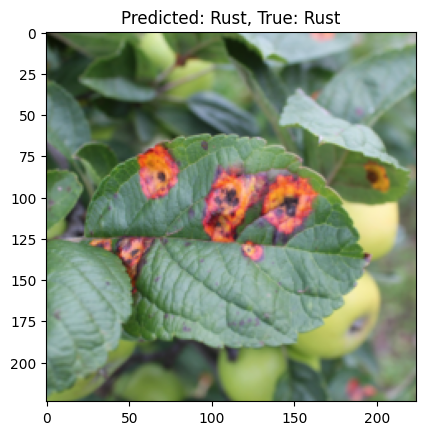

In [23]:
import matplotlib.pyplot as plt

# Function to predict and visualize a single batch from the validation DataLoader
def predict_and_visualize(model, dataloader, device, idx_to_class):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            # Get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Move data to CPU for visualization
            images = images.cpu()
            preds = preds.cpu()
            labels = labels.cpu()

            # Visualize the first image in the batch
            img = images[0]
            pred_label = idx_to_class[preds[0].item()]
            true_label = idx_to_class[labels[0].item()]

            img = img.permute(1, 2, 0)  # Change from CxHxW to HxWxC
            img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Unnormalize
            img = img.numpy()

            plt.imshow(img)
            plt.title(f'Predicted: {pred_label}, True: {true_label}')
            plt.show()

            break 

# Load the image and predict
predict_and_visualize(model, val_loader, device, val_dataset.idx_to_class)
